In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import datetime
import seaborn as sns

In [71]:
# laod the V52 data
# skip the first 12 rows

V52_data_raw = pd.read_excel('V52_exel.xlsx')


In [72]:
# convert the from numeric to datetime
V52_data_raw.index = pd.to_datetime(V52_data_raw['Date'], format='%Y%m%d%H%M')


In [73]:
#describe the V52 raw data
print(V52_data_raw.describe())
#count how many nans we have in the wsp_44m column


               Date       Wsp_44m      Wdir_41m        ActPow         RePow  \
count  5.224100e+04  48988.000000  48988.000000  52103.000000  52103.000000   
mean   2.018067e+11      5.595770    192.776609    139.070329     -0.071636   
std    3.474519e+06      2.796707     88.910389    203.275309      0.634039   
min    2.018010e+11      0.503833      0.001286    -27.466700     -5.744410   
25%    2.018040e+11      3.626873    125.051750     -0.400000     -0.002700   
50%    2.018070e+11      5.185345    198.823000     57.400500     -0.000527   
75%    2.018100e+11      7.081175    266.270000    175.286000      0.002410   
max    2.019010e+11     19.720000    359.997000    867.900000     11.800000   

         ActPow_std   Wsp_44m_std  Wdir_41m_std     stability  
count  52103.000000  48988.000000  48988.000000  52241.000000  
mean      36.724520      0.823869      8.386558      0.513677  
std       46.100481      0.520168      4.740973      0.499818  
min        0.000000      0.00000

In [74]:
print(V52_data_raw['Wsp_44m'].isna().sum())

3253


In [75]:

# plot wind speed data with plotly
fig = px.line(V52_data_raw, x=V52_data_raw.index, y='Wsp_44m')
fig.update_layout(title='Wind Speed (m/s) of V52')
fig.show()

# scatter plot of wind speed vs power
fig = px.scatter(V52_data_raw, x='Wsp_44m', y='ActPow')
fig.update_layout(title='Wind Speed vs Power of V52')
fig.show()


c:\Users\enriq\AppData\Local\Programs\Python\Python310\lib\site-packages\_plotly_utils\basevalidators.py:105: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



## CLEANING THE RAW DATA

In [76]:

V52_data = V52_data_raw.copy()

## FIRST PUT TO NAN VARAIBLES THAT HAVE A STD = 0
# with wsp_44m_std
V52_data.loc[V52_data['Wsp_44m_std'] == 0, :] = np.nan
# with direction
V52_data.loc[V52_data['Wdir_41m_std'] == 0, :] = np.nan






In [77]:
# count how many nans in the Date column
print(V52_data['Date'].isna().sum())

131


In [78]:
V52_data = V52_data.dropna(subset=[V52_data.columns[0]]) # drop rows with nan in the Date column
V52_data['T_i'] = pd.to_datetime(V52_data['Date'].astype('int64'), format='%Y%m%d%H%M')
#get T_i as an array 
T_i = V52_data['T_i'].values
DeltaT = V52_data['T_i'].diff()

In [79]:
LowestWindSpeed = 0.01   # [m/s] anemometer's calm threshold
CrazyWind = 50        # [m/s] 10-minute-mean wind in Denmark has never been this high
maxDeltaU10min = 7.5    # [m/s] the 10-minute mean wind should not jump this much from one period to the next

11.144593724998387


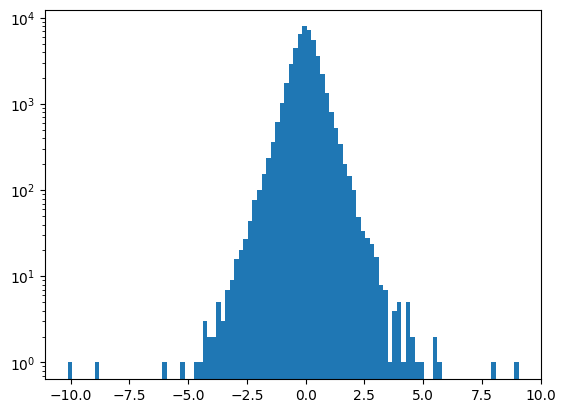

In [85]:
# good assumption?? about 3 std from the mean
plt.yscale('log'); 
plt.hist(np.diff(V52_data['Wsp_44m']),bins=100);
five_std = 4 * V52_data['Wsp_44m'].std()
print(five_std)

In [90]:
# CREATE data-selection "masks" (by using Boolean T/F arrays)

WspOK = ((V52_data['Wsp_44m'] > LowestWindSpeed) & (V52_data['Wsp_44m'] < CrazyWind)) # Boolean (T or F): reject unrealistic wind speeds

DeltaU = np.diff(V52_data['Wsp_44m'])
dU10min = np.empty(DeltaU.shape, dtype='float')
for i in range(len(DeltaU)):
    dU10min[i] = DeltaU[i] / (DeltaT[i].seconds / 600)
DeltaUOK = (DeltaU > -maxDeltaU10min) & (DeltaU < maxDeltaU10min)

OK1 = (WspOK[0:-1] == True) & (DeltaUOK == True)
OK2 = (WspOK[1:] == True) & (DeltaUOK == True)
OK1 = np.append(OK1, True)
OK2 = np.insert(OK2, 0, True)

DataOK = OK1 & OK2 # Final filter in terms of a Boolean array

print(DataOK.sum())
print(len(DataOK) - DataOK.sum())


C:\Users\enriq\AppData\Local\Temp\ipykernel_49604\1541541242.py:8: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`



48842
3268


In [96]:

Timestamp = V52_data[DataOK]['Date']
Wsp = V52_data[DataOK]['Wsp_44m']
wdir = V52_data[DataOK]['Wdir_41m']
# make a new pandas dataframe with the filtered data
V52_data_filtered = pd.DataFrame({'Timestamp': Timestamp, 'Wsp': Wsp, 'Wdir': wdir})
# describe the filtered data
print(V52_data_filtered.describe())

# Compute year and month
Year = np.floor(Timestamp/1e8).astype('int64')
Month = np.floor(np.mod(Timestamp,1e8)/1e6).astype('int64')

          Timestamp           Wsp          Wdir
count  4.884200e+04  48842.000000  48842.000000
mean   2.018068e+11      5.588953    192.746485
std    3.570129e+06      2.785417     88.941080
min    2.018010e+11      0.503835      0.001286
25%    2.018033e+11      3.627852    124.917500
50%    2.018071e+11      5.181375    199.024500
75%    2.018101e+11      7.066813    266.351000
max    2.019010e+11     19.720000    359.997000


In [98]:
# make a plotly timeseries plot of the filtered data
fig = px.line(V52_data_filtered, x='Timestamp', y='Wsp')
fig.update_layout(title='Filtered Wind Speed (m/s) of V52')
fig.show()

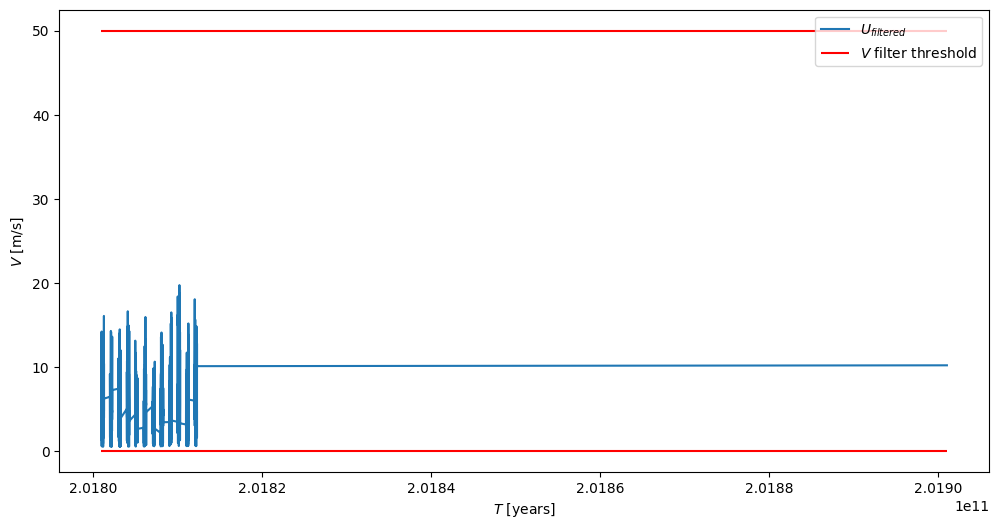

In [95]:
# plot the filtered data to check it:
plt.figure(figsize=(12, 6))
plt.plot(V52_data_filtered['Timestamp'],V52_data_filtered['Wsp'], label='$U_{filtered}$')
plt.hlines([LowestWindSpeed, CrazyWind], Timestamp.min(), Timestamp.max(), 'r', label='$V$ filter threshold')
plt.xlabel("$T$ [years]")
plt.ylabel("$V$ [m/s]")
plt.legend()
plt.show();